In [551]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn import covariance
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
import networkx as nx
from exchange.ftx.client import FtxClient

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

client = FtxClient()


#### Get Data

In [770]:
# Training
formation_start_date = datetime.fromisoformat('2021-07-01 00:00:00+00:00')
formation_end_date = datetime.fromisoformat('2021-09-01 00:00:00+00:00')
minimum_volume = 5000000
resolution = '15m'
futures = client.get_futures()
perps = []
for future in futures:
    if 'PERP' in future['name'] and future['volumeUsd24h'] > minimum_volume:
        perps.append(future['name'])

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('/Users/walidmadaoui/Desktop/ARB/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

formation_prices_df = pd.DataFrame(prices)[formation_start_date:formation_end_date].T.dropna().T
formation_prices_df

Cannot find OP-PERP data


,1INCH-PERP,AAVE-PERP,ADA-PERP,ALGO-PERP,ALT-PERP,ATOM-PERP,AVAX-PERP,AXS-PERP,BCH-PERP,BNB-PERP,...,VET-PERP,WAVES-PERP,XEM-PERP,XLM-PERP,XMR-PERP,XRP-PERP,XTZ-PERP,YFI-PERP,ZEC-PERP,ZIL-PERP
startTime,,,,,,,,,,,,,,,,,,,,,
2021-07-01 00:00:00+00:00,2.4945,247.80,1.369315,0.8731,3293.55,11.8695,11.812,5.708,520.30,299.4925,...,0.089115,16.0020,0.13195,0.277925,218.91,0.694750,3.0274,33600.0,129.22,0.08626
2021-07-01 00:15:00+00:00,2.4969,247.73,1.370415,0.8720,3295.95,11.8140,11.836,5.618,520.00,300.0825,...,0.090085,15.8915,0.13205,0.278275,218.92,0.693250,3.0183,33625.0,128.81,0.08600
2021-07-01 00:30:00+00:00,2.4931,247.56,1.366110,0.8725,3296.10,11.7845,11.849,5.565,520.50,301.0800,...,0.089975,15.8085,0.13380,0.278750,218.79,0.692350,3.0218,33655.0,128.88,0.08604
2021-07-01 00:45:00+00:00,2.4837,248.33,1.366875,0.8695,3292.20,11.7100,11.839,5.523,520.05,300.2400,...,0.090170,15.8280,0.13420,0.278725,218.26,0.691975,3.0187,33620.0,128.79,0.08615
2021-07-01 01:00:00+00:00,2.4916,248.81,1.370215,0.8725,3299.70,11.7580,11.922,5.542,521.75,300.7575,...,0.090130,15.8795,0.13525,0.280300,218.52,0.693975,3.0326,33760.0,129.15,0.08631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 23:00:00+00:00,3.0628,394.41,2.777250,1.1030,5388.75,22.8170,39.454,72.220,635.10,463.0550,...,0.122765,27.7095,0.19240,0.342950,286.85,1.176650,5.1405,38400.0,143.89,0.10795
2021-08-31 23:15:00+00:00,3.0622,395.17,2.778055,1.1038,5407.70,23.2070,39.524,72.452,636.60,464.4425,...,0.122975,27.9580,0.19240,0.343450,287.90,1.178900,5.1708,38430.0,144.21,0.10831
2021-08-31 23:30:00+00:00,3.0577,395.47,2.781645,1.1093,5428.55,22.9885,39.451,72.429,636.30,465.9925,...,0.123335,28.2300,0.19305,0.344200,288.02,1.193500,5.1845,38480.0,144.26,0.10855


#### Functions

In [818]:
def calculate_hurst(df):
    ts = df.values

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0


def calculat_half_life(df):
    df_lag = df.shift(1)
    df_delta = df - df_lag
    lin_reg_model = LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta),1)                    # sklearn needs (row, 1) instead of (row,)
    df_lag = df_lag.values.reshape(len(df_lag),1)
    lin_reg_model.fit(df_lag[1:], df_delta[1:])                           # skip first line nan
    half_life = -np.log(2) / lin_reg_model.coef_.item()
    return half_life


def calculate_johansen(y, p, crit_val=1):
        """
        Get the cointegration vectors at 95% level of significance
        given by the trace statistic test.
        """

        N, l = y.shape
        jres = coint_johansen(y, 0, p)
        trstat = jres.lr1                       # trace statistic
        tsignf = jres.cvt                       # critical values

        r = 0
        for i in range(l):
            if trstat[i] > tsignf[i, crit_val]:     # 0: 90%  1:95% 2: 99%
                r = i + 1
        jres.r = r
        jres.evecr = jres.evec[:, :r]

        return jres


def get_trades(df, entry, mean, stop):
    trades = []
    positions = [0]
    long_entry = mean - entry
    short_entry = mean + entry
    long_stop = mean - stop
    short_stop = mean + stop
    current_pos = 0
    for i in range(1, len(df)):
        if current_pos == 0 and df.iloc[i-1] < long_entry.iloc[i-1] and df.iloc[i] > long_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open long', 'position': 1})
            current_pos = 1
        elif current_pos == 0 and df.iloc[i-1] > short_entry.iloc[i-1] and df.iloc[i] < short_entry.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'open short', 'position': -1})
            current_pos = -1
        elif current_pos == 1 and df.iloc[i] >= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] <= mean.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0})
            current_pos = 0
        elif current_pos == -1 and df.iloc[i] >= short_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0})
            current_pos = 0
        elif current_pos == 1 and df.iloc[i] <= long_stop.iloc[i]:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0})
            current_pos = 0
        elif i == len(df) - 1 and current_pos == -1:
            trades.append({'date': df.index[i], 'trade': 'close short', 'position': 0})
        elif i == len(df) - 1 and current_pos == 1:
            trades.append({'date': df.index[i], 'trade': 'close long', 'position': 0})
        
        positions.append(current_pos)
    
    return (pd.DataFrame(trades), positions)

#### Narrow down coin universe

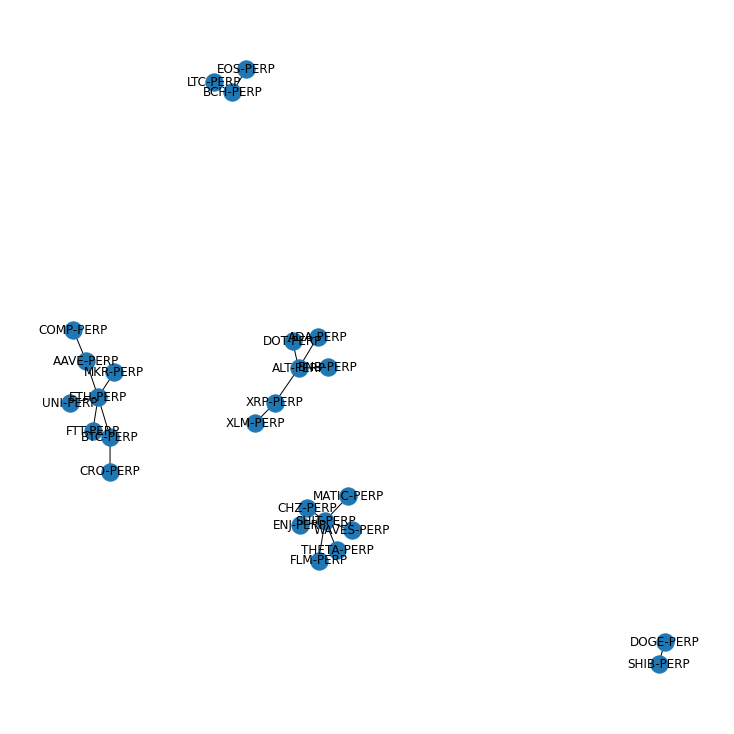

In [772]:
returns = formation_prices_df.pct_change()[1:]

edge_model = covariance.GraphicalLassoCV()
returns /= returns.std(axis=0)
edge_model.fit(returns)
p = edge_model.precision_

#prepare the matrix for network illustration
p = pd.DataFrame(p, columns=formation_prices_df.columns, index=formation_prices_df.columns)
links = p.stack().reset_index()
links.columns = ['var1', 'var2','value']
links=links.loc[ (abs(links['value']) > 0.1) &  (links['var1'] != links['var2']) ]

#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

#### Identify best pair candidates

In [773]:
# Find most mean reverting pairs
ridge = RidgeCV()
unique_pairs = []
possible_pairs = []
clusters = nx.connected_components(G)
for cluster in clusters:
    perps = list(cluster)
    for perp_a in perps:
        for perp_b in perps:
            pair = '{}/{}'.format(perp_a, perp_b)
            if perp_a != perp_b and '{}/{}'.format(perp_b, perp_a) not in unique_pairs:
                
                # regress prices
                ridge_reg = ridge.fit(formation_prices_df[perp_a].values.reshape(-1, 1), formation_prices_df[perp_b].values.reshape(-1, 1))

                # test for mean-reversion
                spread =  formation_prices_df[perp_b] - ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                half_life = calculat_half_life(spread)
                adf = adfuller(spread, 1)
                hurst = calculate_hurst(spread)

                # calculate positions ratio in dollars
                total_size = formation_prices_df[perp_b] + ridge_reg.coef_[0][0] * formation_prices_df[perp_a]
                size_ratio = formation_prices_df[perp_b] / total_size

                possible_pairs.append({
                    'pair': pair,
                    'perp_a': perp_a,
                    'perp_b': perp_b,
                    'beta_units': ridge_reg.coef_[0][0],
                    'half_life': half_life,
                    'adf_pvalue': adf[1],
                    'hurst': hurst,
                    'long_short_position_ratio': size_ratio.mean()
                })

                unique_pairs.append(pair)

possible_pairs = pd.DataFrame(possible_pairs)
top_10_pairs = possible_pairs[(possible_pairs['half_life'] > 0)].sort_values(['hurst'])[:10]
top_10_pairs

,pair,perp_a,perp_b,beta_units,half_life,adf_pvalue,hurst,long_short_position_ratio
59,CHZ-PERP/ENJ-PERP,CHZ-PERP,ENJ-PERP,4.784287,203.476729,0.053772,0.377149,0.511854
46,SHIT-PERP/FLM-PERP,SHIT-PERP,FLM-PERP,0.000121,142.404101,0.008504,0.385018,0.425557
45,BCH-PERP/LTC-PERP,BCH-PERP,LTC-PERP,0.262477,86.773567,0.000263,0.421421,0.507817
67,DOGE-PERP/SHIB-PERP,DOGE-PERP,SHIB-PERP,0.000013,466.033015,0.250882,0.423296,0.700796
64,THETA-PERP/ENJ-PERP,THETA-PERP,ENJ-PERP,0.219402,578.878562,0.411460,0.423758,0.515965
4,UNI-PERP/MKR-PERP,UNI-PERP,MKR-PERP,102.008440,244.005931,0.096016,0.426871,0.567140
50,SHIT-PERP/ENJ-PERP,SHIT-PERP,ENJ-PERP,0.000262,263.988708,0.092549,0.428818,0.512705
15,CRO-PERP/MKR-PERP,CRO-PERP,MKR-PERP,27100.707690,131.763511,0.007676,0.431887,0.460715
53,FLM-PERP/MATIC-PERP,FLM-PERP,MATIC-PERP,1.708951,251.679406,0.074794,0.434263,0.586676
55,FLM-PERP/ENJ-PERP,FLM-PERP,ENJ-PERP,2.125960,147.200621,0.008814,0.436068,0.590545


### Backtest

In [774]:
trading_period_hours = 24*5
trading_start_date = formation_end_date
trading_end_date = trading_start_date + timedelta(hours=trading_period_hours)
trading_prices_df = pd.DataFrame(prices)[trading_start_date:trading_end_date].T.dropna().T

trading_data = {}
#for row in top_10_pairs


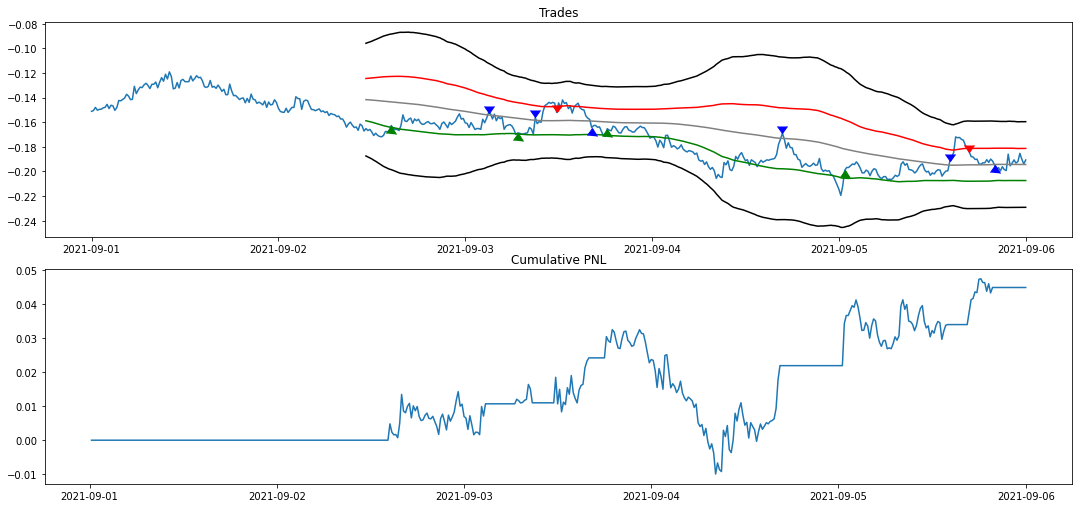

In [843]:
taker_fee = 0.0005
std_entry_multiple = 1.5
std_stop_multiple = 4
half_life_multiple = 1

row = top_10_pairs.iloc[1]
formation_spread = (formation_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
formation_mean = formation_spread.mean()
formation_std = formation_spread.std()

# trades
trading_spread = (trading_prices_df[[row['perp_a'], row['perp_b']]] * [-row['beta_units'], 1]).sum(axis=1)
rolling_size_dollars = ((trading_prices_df[[row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]).sum(axis=1))
rolling_mean = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.mean)
rolling_std = trading_spread.rolling(window=int(row['half_life'] * half_life_multiple)).apply(np.std)
rolling_entry = std_entry_multiple * rolling_std
rolling_stop = std_stop_multiple * rolling_std
trades, positions = get_trades(trading_spread, rolling_entry, rolling_mean, rolling_stop)

# pnl
trades_fee = ((trading_prices_df.loc[trades['date'], [row['perp_a'], row['perp_b']]] * [row['beta_units'], 1]) * taker_fee).sum(axis=1) # fee cost based on 2 trades per entry/close, matching size of 1 unit of b and its equivalent of a
pnl = trading_spread.diff() * positions
pnl_after_fees = pnl - trades_fee.reindex(pnl.index, fill_value=0)
cumulative_pnl = pnl_after_fees.cumsum()

# visualization
fig, axs = plt.subplots(2,1, figsize=(15,7))
fig.tight_layout()
axs[0].plot(trading_spread)
axs[0].title.set_text('Trades')
axs[0].plot(rolling_mean, color='grey')
axs[0].plot(rolling_mean + rolling_entry, color='red')
axs[0].plot(rolling_mean + rolling_stop, color='black')
axs[0].plot(rolling_mean - rolling_entry, color='green')
axs[0].plot(rolling_mean - rolling_stop, color='black')
axs[0].plot(trading_spread[trades[trades['trade'] == 'open short']['date']], linestyle='None', marker=7, color='r', markersize=10)
axs[0].plot(trading_spread[trades[trades['trade'] == 'open long']['date']], linestyle='None', marker=6, color='g', markersize=10)
axs[0].plot(trading_spread[trades[trades['trade'] == 'close short']['date']], linestyle='None', marker=6, color='b', markersize=10)
axs[0].plot(trading_spread[trades[trades['trade'] == 'close long']['date']], linestyle='None', marker=7, color='b', markersize=10)

axs[1].plot(cumulative_pnl)
axs[1].title.set_text('Cumulative PNL')
